# Data Transformations for PCA
Principal Component Analysis (PCA) works by finding linear correlations. It consists of linear combinations of the original variables of the dataset by detecting linear relationships between variables. Therefore, if there are outliers or if variables are not linear (e.g. scaled, etc.) then the correlation coefficients can be lower. 

### Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.externals import joblib
import matplotlib.pyplot as plt

### Import data

In [2]:
df_original = joblib.load('../3.customer_segmentation/data/df_original.p')
df = joblib.load('../3.customer_segmentation/data/df.p')

In [3]:
df.sample(2)

,index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,Dayofweek,Hour
215250,305356,563686,22704,WRAP RED APPLES,25,2011-08-18 12:30:00,0.42,13098.0,United Kingdom,8,3,12
22957,34032,539316,21281,VINTAGE KITCHEN PRINT SEAFOOD,16,2010-12-16 18:38:00,2.55,17848.0,United Kingdom,12,3,18


### Handle categorical data
Before transforming the data, we should figure out how we want to handle our categorical data.

In [4]:
df['Description'].nunique()

3868

In [5]:
df['CustomerID'].nunique()

4297

In [6]:
# Calculate the number of unique customers from each country

cust_country = df[['Country', 'CustomerID']].drop_duplicates()

In [7]:
count_cust_country = cust_country.groupby(['Country'])['CustomerID'].aggregate('count').reset_index().sort_values(by='CustomerID', ascending=False).head(10)

In [8]:
count_cust_country['Percentage'] = count_cust_country['CustomerID'] / 4297

In [9]:
count_cust_country

,Country,CustomerID,Percentage
35,United Kingdom,3886,0.904352
14,Germany,93,0.021643
13,France,86,0.020014
30,Spain,29,0.006749
3,Belgium,25,0.005818
32,Switzerland,21,0.004887
26,Portugal,19,0.004422
18,Italy,14,0.003258
12,Finland,11,0.002560
1,Austria,11,0.002560


Since there are too many unique values in our categorical features (3868), and since the United Kingdom makes up the most of our purchases anyway, we can just ignore our categorical features (instead of trying to one-hot encode them, which will grow our datasize expoentially).

In [10]:
# Create a new dataframe with just numeric data (aka drop categorical columns)

numeric_df = df[['Quantity', 'UnitPrice', 'Month', 'Dayofweek', 'Hour']]

No NaN values to fill - yay!

## Exploratory Data Analysis using PCA
PCA is a great tool for dimensionality reduction and visualizing high-dimensional datasets. Since most datasets have a large number of variables, they have a high number of dimensions along which the data is distributed. Visually exploring the data can then become challenging, and unless we have a VR set, we use dimensionality reduction techniques (like PCA) to visualize our data.

* https://www.youtube.com/watch?v=BfTMmoDFXyE
* https://www.youtube.com/watch?v=kw9R0nD69OU

### Fill NaN values with the mean
Fill NaN values, scale and log (unskew) the data before putting it through PCA.

In [11]:
numeric_df.isnull().sum()

Quantity     0
UnitPrice    0
Month        0
Dayofweek    0
Hour         0
dtype: int64

Feed the data through PCA first to see what we get (before dropping outliers, scaling and logging)

In [12]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(numeric_df)

In [13]:
# from sklearn.decomposition import PCA
# pca = PCA()
# df_pca = pca.fit_transform(df_scaled)

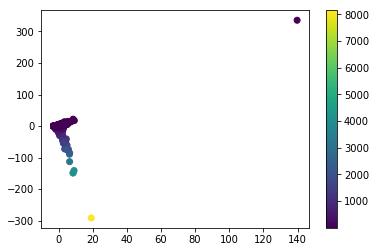

In [14]:
# plt.scatter(df_pca[:,0], df_pca[:,1],c=numeric_df['UnitPrice'])
# plt.colorbar()

### Remove outliers

In [15]:
# Find the outliers

numeric_df.describe()

,Quantity,UnitPrice,Month,Dayofweek,Hour
count,380580.000000,380580.000000,380580.000000,380580.000000,380580.000000
mean,12.823582,3.134235,7.412985,2.620611,12.714449
std,127.733673,22.430764,3.359802,1.932302,2.264485
min,1.000000,0.001000,1.000000,0.000000,6.000000
25%,2.000000,1.250000,5.000000,1.000000,11.000000
50%,6.000000,1.950000,8.000000,2.000000,13.000000
75%,12.000000,3.750000,10.000000,4.000000,14.000000
max,74215.000000,8142.750000,12.000000,6.000000,20.000000


In [16]:
clean_df = numeric_df[numeric_df['Quantity']!=74215]

In [17]:
clean_df = clean_df[clean_df['UnitPrice']!=8142.750000]

In [18]:
clean_df.shape

(380578, 5)

In [19]:
# Compare with original - did we drop 2 rows as expected?

numeric_df.shape

(380580, 5)

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(clean_df)

In [22]:
from sklearn.decomposition import PCA

In [23]:
pca = PCA()
df_pca = pca.fit_transform(df_scaled)

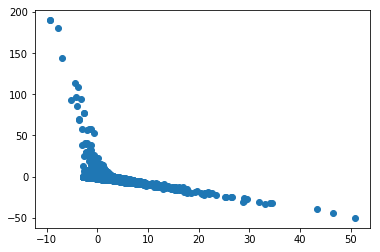

In [24]:
plt.scatter(df_pca[:,0], df_pca[:,1])

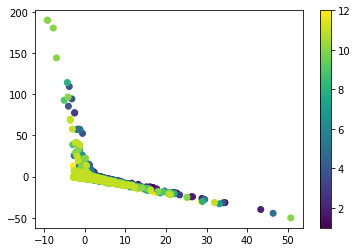

In [25]:
plt.scatter(df_pca[:,0], df_pca[:,1],c=clean_df['Month'])
plt.colorbar()

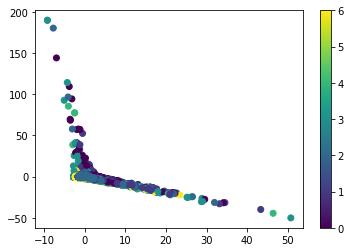

In [26]:
plt.scatter(df_pca[:,0], df_pca[:,1],c=clean_df['Dayofweek'])
plt.colorbar()

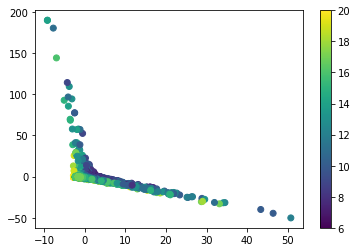

In [27]:
plt.scatter(df_pca[:,0], df_pca[:,1],c=clean_df['Hour'])
plt.colorbar()

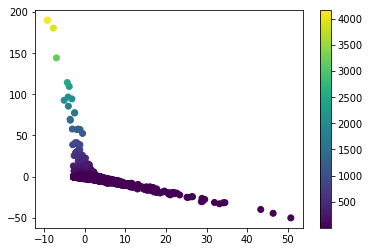

In [28]:
plt.scatter(df_pca[:,0], df_pca[:,1],c=clean_df['UnitPrice'])
plt.colorbar()

This is what we get after dropping outliers. Next, let's do some data transformations and see how that affects our data.

### Data transformations
K-means clustering requires continuous variables and works best with relatively normally-distributed, standardized input variables. Standardizing the input variables is quite important; otherwise, input variables with larger variances will have commensurately greater influence on the results.

In [29]:
# Make a copy before doing transformations

df_logged = clean_df.copy()

In [30]:
for col in df_logged.columns:
    df_logged[col] = np.log(1+df_logged[col])

In [31]:
scaler = StandardScaler()
scaler.fit(df_logged)
new_cols = df_logged.columns
transformed_df = pd.DataFrame(scaler.transform(df_logged), columns=new_cols)

In [32]:
transformed_df.mean()

Quantity     5.618656e-14
UnitPrice   -4.552089e-15
Month       -2.633889e-12
Dayofweek    1.954163e-14
Hour         1.661245e-14
dtype: float64

In [33]:
transformed_df.std()

Quantity     1.000001
UnitPrice    1.000001
Month        1.000001
Dayofweek    1.000001
Hour         1.000001
dtype: float64

In [34]:
pca = PCA()
df_pca = pca.fit_transform(transformed_df)

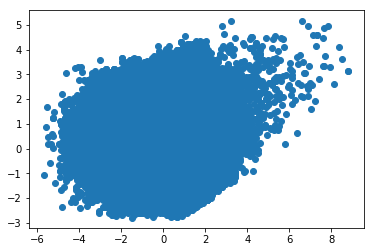

In [35]:
plt.scatter(df_pca[:,0], df_pca[:,1])

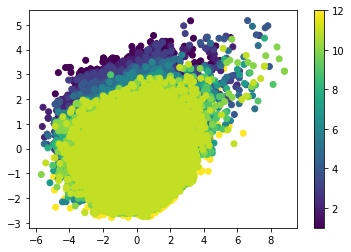

In [36]:
plt.scatter(df_pca[:,0], df_pca[:,1],c=clean_df['Month'])
plt.colorbar()

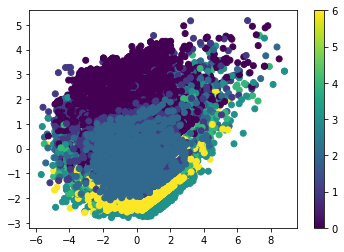

In [37]:
plt.scatter(df_pca[:,0], df_pca[:,1],c=clean_df['Dayofweek'])
plt.colorbar()

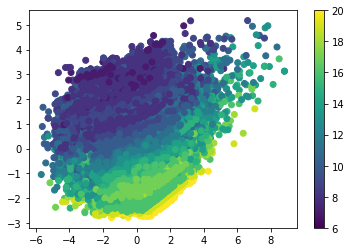

In [38]:
plt.scatter(df_pca[:,0], df_pca[:,1],c=clean_df['Hour'])
plt.colorbar()

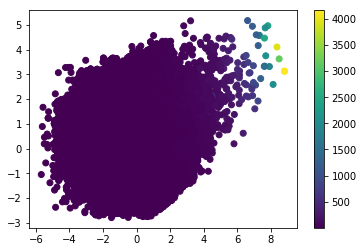

In [39]:
plt.scatter(df_pca[:,0], df_pca[:,1],c=clean_df['UnitPrice'])
plt.colorbar()

### Export the data

In [40]:
joblib.dump(df_pca, '../3.customer_segmentation/data/df_pca.p')

['../3.customer_segmentation/data/df_pca.p']

In [41]:
joblib.dump(transformed_df, '../3.customer_segmentation/data/transformed_df.p')

['../3.customer_segmentation/data/transformed_df.p']